In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

In [2]:
class CoucheNeuronale:
    def __init__(self, nombre_entrees, nombre_neurones, activation):
        if activation == 'relu':
            # Initialisation des poids pour la fonction relu
            # La fonction relu sera utilisée pour les couches cachées.
            # initialisation de He = on divise par racine carrée de 2 sur nombre d'entrées
            # cette méthode consiste à calculer des valeurs aléatoires qui suivent une distribution gaussienne de 
            #probabilité avec valeur moyenne nulle et écart-type égale à 2/n, où n est le nombre d’entrées.
            self.W = np.random.randn(nombre_neurones, nombre_entrees) * np.sqrt(2. / nombre_entrees)
            #sans cette division, le modèle n'est pas concluant

        else:
            # Initialisation standard pour sigmoid
            self.W = np.random.randn(nombre_neurones, nombre_entrees) * np.sqrt(1. / nombre_entrees)
        # initialisation des biais avec des 0
        self.B = np.zeros((nombre_neurones, 1))
        self.activation = activation

    #fonction sigmoid : utilisée pour la dernière couche du réseau de neuronnes
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    # fonction relu : utilisée pour les couches cachées
    def relu(self, x):
        return np.maximum(0, x)

    # propagation
    def forward(self, X):
        self.Z = np.dot(self.W, X) + self.B
        if self.activation == 'sigmoid':
            self.R = self.sigmoid(self.Z)
        elif self.activation == 'relu':
            self.R = self.relu(self.Z)
        return self.R

    
    def backward(self, X, dA_prec, learning_rate): #DA_prec correspond à R-Y =>l'erreur
        m = X.shape[1]
        if self.activation == 'sigmoid':
            #utilisation de la dérivée de la fonction sigmoid
            dZ = dA_prec * self.sigmoid(self.Z) * (1 - self.sigmoid(self.Z))
        elif self.activation == 'relu':
            #dérivée de la fonction relu 
            #en deux partie : si Z>0 alors dérivée = 1 sinon = 0
            dZ = dA_prec * (self.Z > 0).astype(int)

        dW = np.dot(dZ, X.T) / m # Gradient par rapport aux poids
        dB = np.sum(dZ, axis=1, keepdims=True) / m
        dR = np.dot(self.W.T, dZ)  # Gradient par rapport à l'entrée

        self.W -= learning_rate * dW
        self.B -= learning_rate * dB

        return dR

In [3]:
def charger_images(base_path, test_size=0.2):
    images = []
    labels = []
    
    for chiffre in range(10):  # Pour chaque chiffre de 0 à 9
        dossier_chiffre = os.path.join(base_path, str(chiffre))  # Chemin du dossier pour le chiffre
        for i in range(101):  # Pour chaque image de 0.jpg à 100.jpg
            image_path = os.path.join(dossier_chiffre, f"{i}.jpg")
            if os.path.exists(image_path):
                with Image.open(image_path) as img:
                    img_array = np.asarray(img)
                    img_array = img_array / 255.0  # Normalisation
                    images.append(img_array.flatten())  # Aplatir l'image et ajouter au tableau
                    labels.append(chiffre)  # Ajouter l'étiquette correspondant au chiffre
    
    images = np.array(images)
    labels = np.array(labels)

    # Mélanger les données
    indices = np.arange(images.shape[0])
    np.random.shuffle(indices)
    images = images[indices]
    labels = labels[indices]
    
    # Diviser les données en ensembles d'entraînement et de test
    split_idx = int(images.shape[0] * (1 - test_size))
    X_train, X_test = images[:split_idx], images[split_idx:]
    y_train, y_test = labels[:split_idx], labels[split_idx:]
    
    return X_train, X_test, y_train, y_test


In [4]:
chemin_dataset = "C:/Users/jehan/OneDrive - Université Clermont Auvergne/Documents/BUT SD/semestre 4/PTUT/Chiffres/"
X_train, X_test, y_train, y_test = charger_images(chemin_dataset, test_size=0.2)


In [5]:
# Convertir les étiquettes en vecteurs one-hot
def one_hot_encode(labels, num_classes=10):
    return np.eye(num_classes)[labels].T

Y_train = one_hot_encode(y_train)
Y_test = one_hot_encode(y_test)

In [6]:
def entrainer_reseau(X_train, Y_train, couche_cachees, couche_sortie, epochs, learning_rate):
    loss_history = []
    #nombre epochs = nombre de fois que le modèle va voir toutes les données
    for epoch in range(epochs):
        A = []
        # Propagation avant
        X = X_train
        # liste des sorties de chaque couche
        A.append(X)
        # on parcourt les couches cachées
        for couche in couche_cachees:
            #on ajoute la sortie de chaque couche à la liste A
            A.append(couche.forward(X))
            #on prend la sortie de la couche précédente comme entrée de la couche suivante
            X = couche.forward(X)
        #même chose pour la couche de sortie
        n = len(A) - 1
        A_sortie = couche_sortie.forward(A[n])
        
        # Calcul de la perte (erreur quadratique moyenne)
        loss = np.mean((A_sortie - Y_train) ** 2)
        loss_history.append(loss)
        
        # Rétropropagation
        # on commence par calculer la différence entre la sortie attendue et la sortie de la couche de sortie
        diff = A_sortie - Y_train
        
        # on commence par la couche de sortie
        
        dA_prec = couche_sortie.backward(A[n], diff, learning_rate)
        # on parcourt les couches cachées dans l'odre inverse
        W = [couche_sortie.W]
        B = [couche_sortie.B]
        for couche in couche_cachees[::-1]:#permet inverser odre
            dA_prec = couche.backward(A[n-1], dA_prec, learning_rate)
            W.append(couche.W)
            B.append(couche.B)
            n -= 1 
        
        # Affichage de la perte
        if epoch % 100 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss}")
    
    return loss_history, W, B



In [7]:
couche_cachees = [CoucheNeuronale(100, 60, 'relu'), CoucheNeuronale(60, 30, 'relu')]
couche_sortie = CoucheNeuronale(30, 10, 'sigmoid')

In [8]:
loss_history = entrainer_reseau(X_train.T, Y_train, couche_cachees, 
                 couche_sortie, epochs=10000, learning_rate=0.1)

Epoch 1/10000, Loss: 0.27181110554172


Epoch 101/10000, Loss: 0.08902741275955599
Epoch 201/10000, Loss: 0.08347149064957861
Epoch 301/10000, Loss: 0.07532289833109235
Epoch 401/10000, Loss: 0.06751517230269743
Epoch 501/10000, Loss: 0.05954617195400895
Epoch 601/10000, Loss: 0.05167288995271063
Epoch 701/10000, Loss: 0.044676559577643236
Epoch 801/10000, Loss: 0.038682868090066956
Epoch 901/10000, Loss: 0.033571696217244776
Epoch 1001/10000, Loss: 0.029384949002715884
Epoch 1101/10000, Loss: 0.02596935259549397
Epoch 1201/10000, Loss: 0.02317134851480629
Epoch 1301/10000, Loss: 0.020827576898441134
Epoch 1401/10000, Loss: 0.018844039652103732
Epoch 1501/10000, Loss: 0.017154530611768734
Epoch 1601/10000, Loss: 0.015706359523847187
Epoch 1701/10000, Loss: 0.014444038258053751
Epoch 1801/10000, Loss: 0.013333996271934614
Epoch 1901/10000, Loss: 0.012345734050415126
Epoch 2001/10000, Loss: 0.011459215579342149
Epoch 2101/10000, Loss: 0.010662003078348744
Epoch 2201/10000, Loss: 0.00994480952299916
Epoch 2301/10000, Loss: 0.00

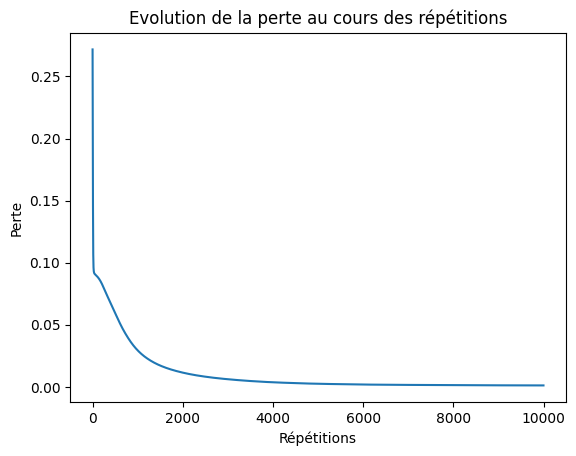

In [9]:
"""
couche1 = CoucheNeuronale(100, 32, 'relu')
couche2 = CoucheNeuronale(32, 10, 'sigmoid')
loss_history=entrainer_reseau(X_train.T, Y_train, couche1, couche2, epochs=10000, learning_rate=0.1)
"""
# Affichage de la perte
plt.plot(loss_history[0])
plt.title('Evolution de la perte au cours des répétitions')
plt.xlabel('Répétitions')
plt.ylabel('Perte')
plt.show()


In [10]:
def evaluer_modele(X_test, Y_test, liste_couches, couche_sortie):
    # Propagation avant sur l'ensemble de test
    A = []
    X = X_test
    A.append(X)
    for couche in liste_couches:
        A.append(couche.forward(X))
        X = couche.forward(X)
    A_sortie = couche_sortie.forward(A[-1])

    # Prédictions : récupérer l'indice de la plus grande probabilité pour chaque exemple
    predictions = np.argmax(A_sortie, axis=0)
    labels_verites = np.argmax(Y_test, axis=0)  # Assurez-vous que Y_test est dans le format correct
    
    # Calcul de la précision
    precision = np.mean(predictions == labels_verites)
    return precision

In [11]:
# Évaluation de la précision du modèle sur l'ensemble de test
precision = evaluer_modele(X_test.T, Y_test, couche_cachees, couche_sortie)
print(f"Précision du modèle sur l'ensemble de test : {precision * 100:.2f}%")

Précision du modèle sur l'ensemble de test : 87.13%


In [12]:
def precision_par_chiffre(X_test, Y_test, liste_couches, couche_sortie ):
    # Propagation avant sur l'ensemble de test
    A = []
    X = X_test
    A.append(X)
    for couche in liste_couches:
        A.append(couche.forward(X))
        X = couche.forward(X)
    A_sortie = couche_sortie.forward(A[-1])
    
    predictions = np.argmax(A_sortie, axis=0)
    labels_verites = np.argmax(Y_test, axis=0)
    
    precision_par_classe = np.zeros(10)  # Pour stocker la précision de chaque classe
    
    for classe in range(10):  # Pour chaque classe de chiffre de 0 à 9
        indices_classe = labels_verites == classe  # Trouver où les vraies étiquettes sont égales à la classe
        predictions_classe = predictions[indices_classe]  # Filtrer les prédictions pour ces indices
        labels_verites_classe = labels_verites[indices_classe]  # Filtrer les vraies étiquettes pour ces indices
        # Calculer la précision pour cette classe
        precision_classe = np.mean(predictions_classe == labels_verites_classe)
        precision_par_classe[classe] = precision_classe
    
    return precision_par_classe



In [13]:
# Calculer la précision par chiffre sur l'ensemble de test

precision_chiffre = precision_par_chiffre(X_test.T, Y_test, couche_cachees, couche_sortie)
# Afficher la précision pour chaque chiffre
for chiffre in range(10):
    print(f"Précision pour le chiffre {chiffre}: {precision_chiffre[chiffre] * 100:.2f}%")

Précision pour le chiffre 0: 82.61%
Précision pour le chiffre 1: 83.33%
Précision pour le chiffre 2: 94.44%
Précision pour le chiffre 3: 71.43%
Précision pour le chiffre 4: 95.45%
Précision pour le chiffre 5: 90.91%
Précision pour le chiffre 6: 100.00%
Précision pour le chiffre 7: 90.00%
Précision pour le chiffre 8: 76.47%
Précision pour le chiffre 9: 87.50%


In [14]:
def reseau(image, W, B) :
    image = Image.open(image)
    image = image.convert('L')
    # Dimensions de l'image
    longueur = float(image.size[0])
    hauteur = float(image.size[1])

    #cree une nouvelle image
    nouvelleImage = Image.new("L", (10, 10), (255))

    # redimensionnement de l'image
    img = image.resize((10, 10))

    X = list(img.getdata())
    X = np.array(X)
    X = X.reshape(-1, 1)
    X = X / 255.0
    n = len(W) - 1
    for i in range(n+1):
        p = n - i
        Z = np.dot(W[p], X) + B[p]
        if i == len(W)-1:
            R = 1 / (1 + np.exp(-Z))
        else:
            R = np.maximum(0, Z)
        X = R
    X = X*100
    res = np.arange(10)
    res = np.hstack((res.reshape(-1,1),X))
    return res
W = loss_history[1]
B = loss_history[2]

    


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def afficher_tableau_avec_couleur(tableau):
    # Extraire les chiffres et les valeurs
    chiffres = tableau[:, 0].astype(int)
    valeurs = tableau[:, 1].astype(float)

    # Trouver la valeur maximale
    valeur_max = np.max(valeurs)

    # Créer une palette de couleurs en utilisant seaborn
    couleur_palette = sns.color_palette("coolwarm", len(valeurs))

    # Créer un sous-tracé pour le tableau
    fig, ax = plt.subplots(figsize=(8, 4))

    # Afficher un barplot avec chaque chiffre coloré en fonction de sa valeur
    bars = plt.bar(chiffres, valeurs, color=couleur_palette)

    # Colorer le chiffre avec la valeur maximale en rouge
    bars[np.argmax(valeurs)].set_color('red')

    # Ajouter des titres et des étiquettes
    plt.xlabel('Chiffre')
    plt.ylabel('Valeur')
    plt.title('Tableau avec couleur')
    plt.xticks(chiffres)

    # Afficher le tableau
    plt.show()




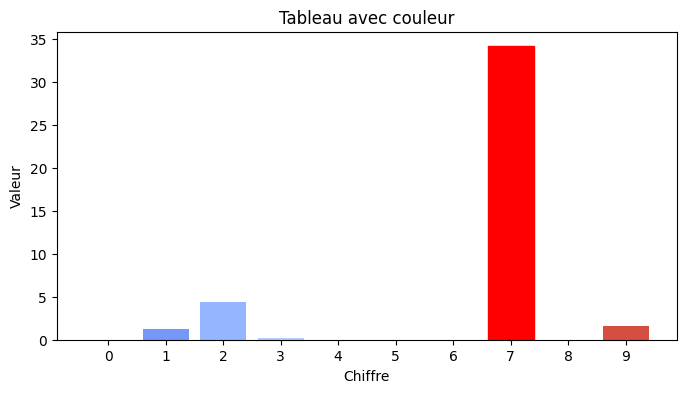

In [46]:
resultat = reseau("chiffres_test/7_g.png", W, B)
afficher_tableau_avec_couleur(resultat)

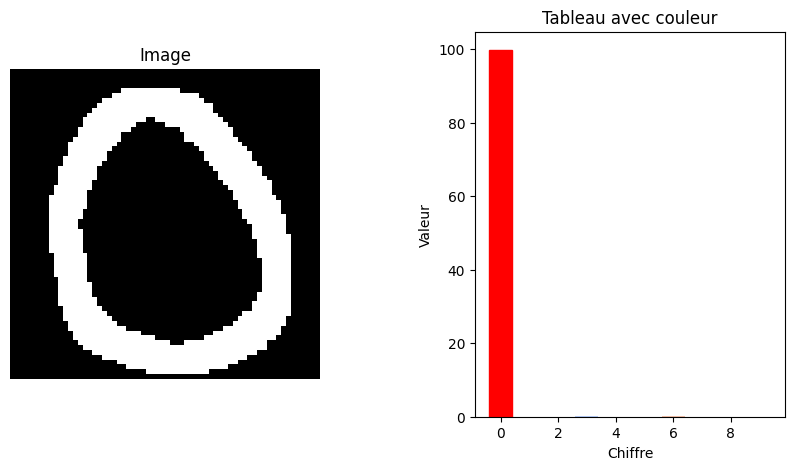

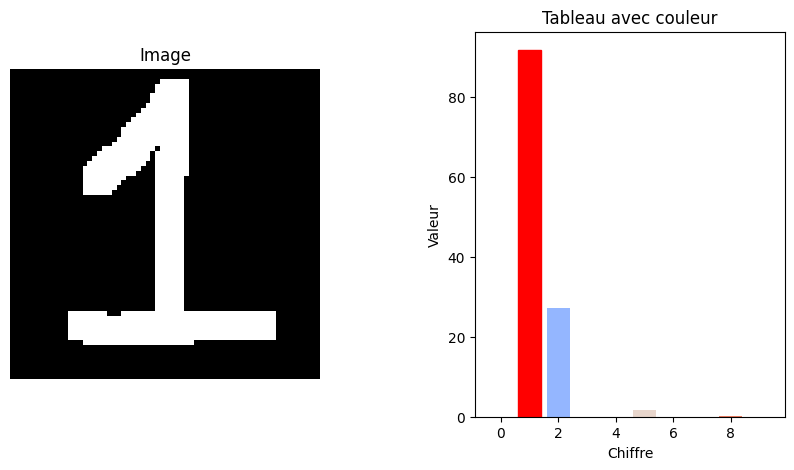

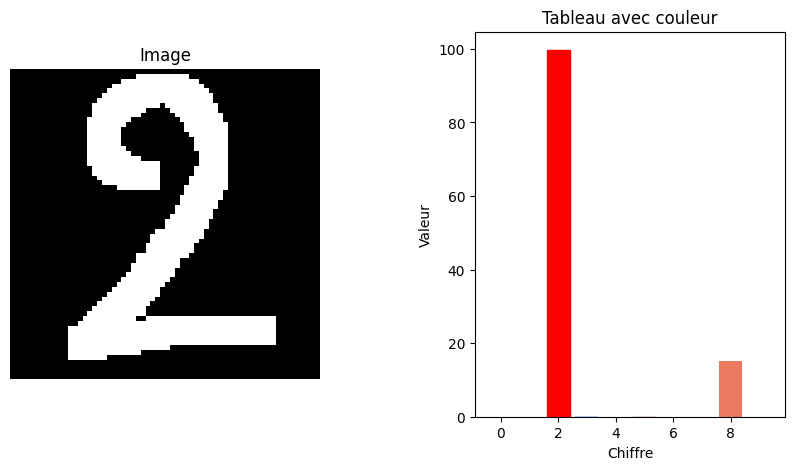

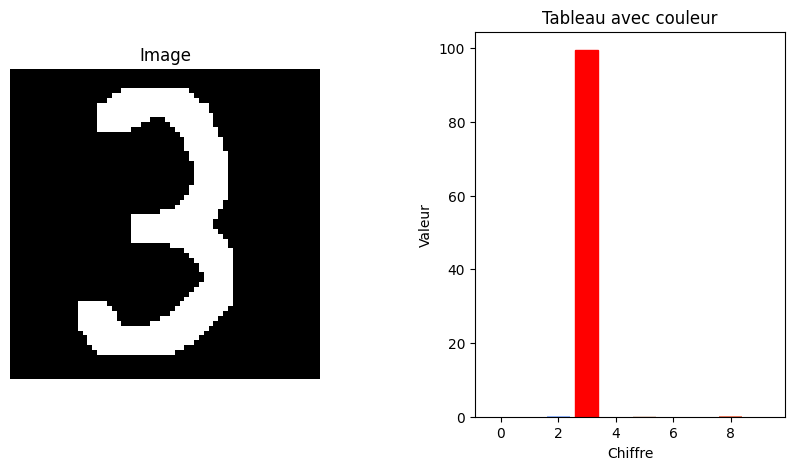

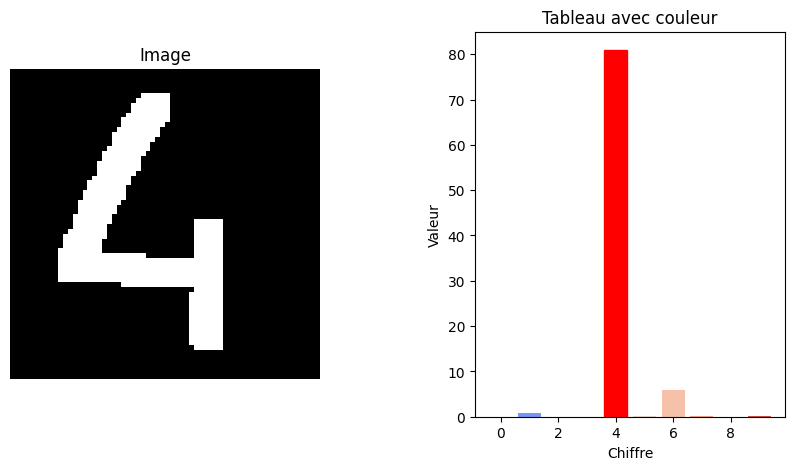

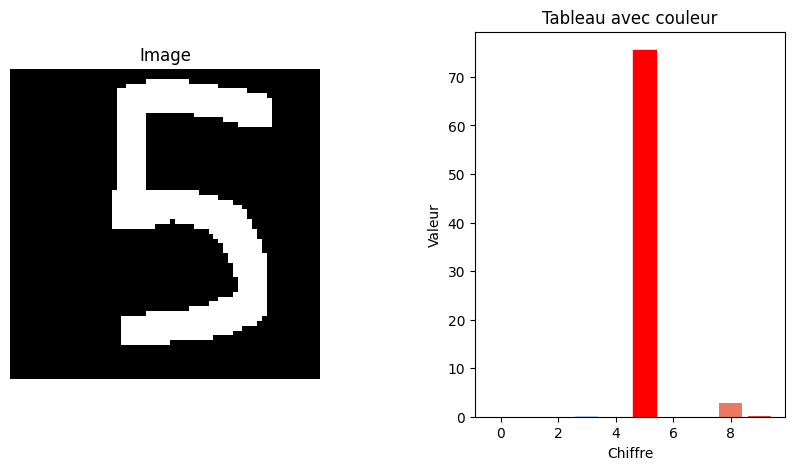

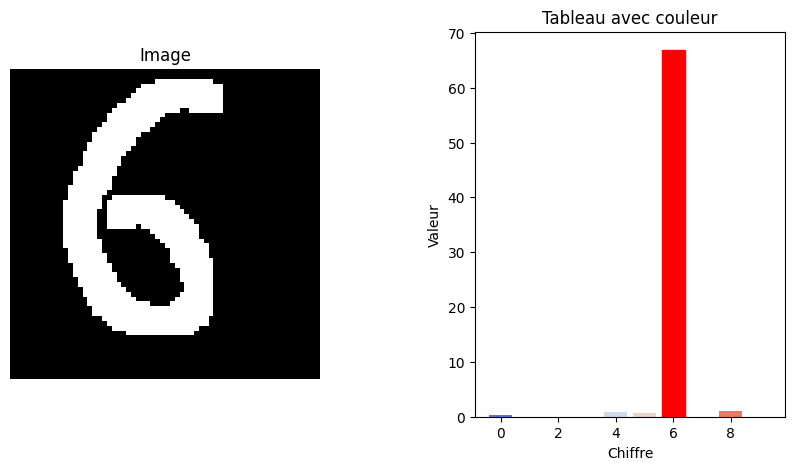

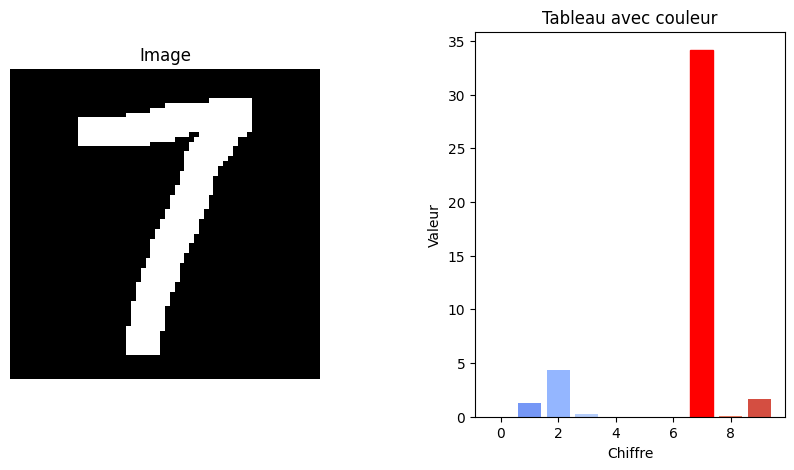

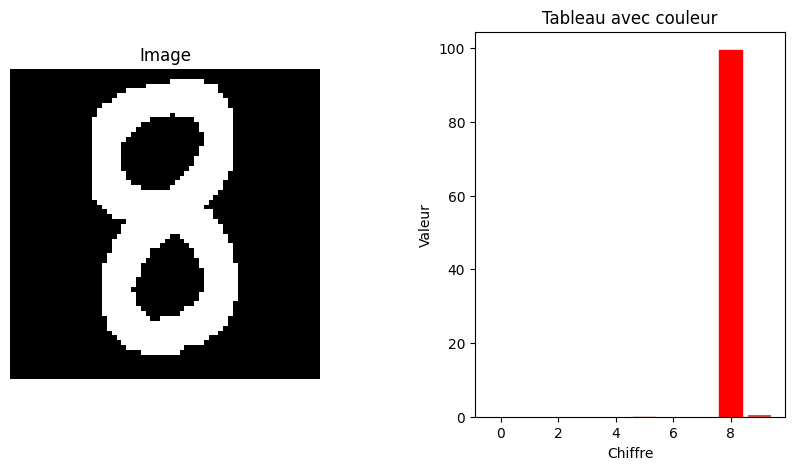

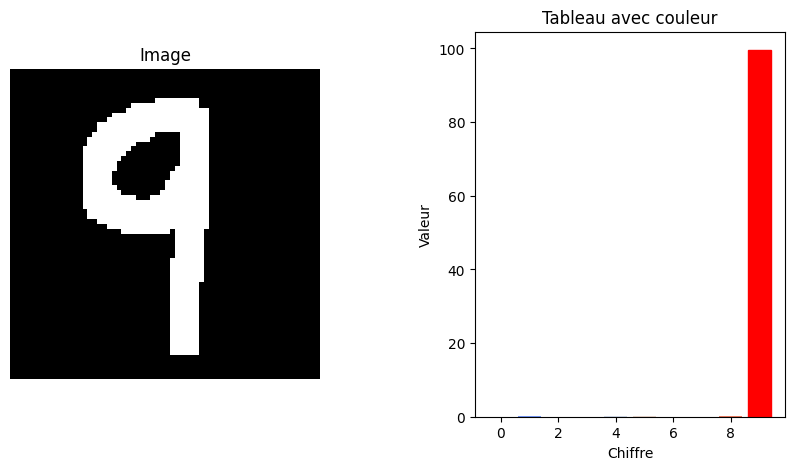

In [48]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Chemin vers le dossier contenant les images
dossier_images = "chiffres_test"

# Parcourir toutes les images du dossier
for fichier in os.listdir(dossier_images):
    if fichier.endswith(".png"):  # Vérifier si le fichier est une image PNG
        chemin_image = os.path.join(dossier_images, fichier)
        # Prédire en utilisant votre fonction reseau
        resultat = reseau(chemin_image, W, B)

        # Ouvrir l'image
        image = Image.open(chemin_image)

        # Afficher l'image et le graphique côte à côte
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

        # Afficher l'image sur le premier axe
        ax1.imshow(image)
        ax1.axis('off')  # Masquer les axes de l'image
        ax1.set_title('Image')

        # Afficher le graphique sur le deuxième axe
        chiffres = resultat[:, 0].astype(int)
        valeurs = resultat[:, 1].astype(float)
        couleur_palette = sns.color_palette("coolwarm", len(valeurs))
        bars = ax2.bar(chiffres, valeurs, color=couleur_palette)
        bars[np.argmax(valeurs)].set_color('red')  # Colorer la barre avec la valeur maximale en rouge
        ax2.set_xlabel('Chiffre')
        ax2.set_ylabel('Valeur')
        ax2.set_title('Tableau avec couleur')

        # Ajuster l'espace entre les subplots
        plt.subplots_adjust(wspace=0.5)

        # Afficher le résultat
        plt.show()
